In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py

import tools
import constants as cst
from geometry import LightGeometry
#from orbdata import GetOrbData_tb
from orbdata_Hqpgw_new import GetOrbData_tb
#from orbdata_blackp import GetOrbData_tb
from pes_intensity import CalcAtomicMatrixElements
from band_tools import GetEshiftGap, GetBandsVect, GetIntensity, PlotIntensity, PlotCDAD
# ---- external modules -----
from python_w90 import wann90_tb

In [2]:
def GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon,project_band=-1):
    wphot = photon['wphot'] / cst.Ry
    alpha = photon['alpha']/180. * np.pi
    Vin = photon['Vin'] / cst.Ry
    Phiw = photon['Phiw'] / cst.Ry
    Eshift = photon['Eshift'] / cst.Ry
    rint = photon['rint']
    eta = photon['eta']

    pol_tag = polarization['tag']
    pol = polarization['vector']

    kdir = kpath['dir']
    kpts = np.zeros([kpath['nk'],2])
    if kdir == 'x':

        kpts[:,0] = np.linspace(kpath['kmin'], kpath['kmax'], kpath['nk'])
        kpoints = np.linspace(kpath['kmin'], kpath['kmax'], kpath['nk'])
    if kdir == 'y':

        kpts[:,1] = np.linspace(kpath['kmin'], kpath['kmax'], kpath['nk'])
        kpoints = np.linspace(kpath['kmin'], kpath['kmax'], kpath['nk'])
    if kdir != 'y' and  kdir != 'x':
        angulo = kpath['angulo']
        #print(np.cos(angulo),np.sin(angulo))
        kpts[:,0] = np.linspace(kpath['kmin'], kpath['kmax'], kpath['nk'])*np.cos(angulo)
        kpts[:,1] = np.linspace(kpath['kmin'], kpath['kmax'], kpath['nk'])*np.sin(angulo)
        
        kpoints = np.linspace(-np.sqrt((kpath['kmin']*np.cos(angulo))**2+(kpath['kmin']*np.sin(angulo))**2), np.sqrt((kpath['kmax']*np.cos(angulo))**2+(kpath['kmax']*np.sin(angulo))**2), kpath['nk'])

    orb = GetOrbData_tb(rint[0], rint[1], rint[2])

    ws_shift = ws - Phiw
    mel_at = CalcAtomicMatrixElements(orb,ws_shift,wphot,Vin,eta,kpts)

    #--------------------------------------------------------------------------------------
    system="BlackP"
    path = "../../DATA/data_excitons/"+system+"/"
    nkx=72
    nky=72
    nkz=72
    #fname = path + "Hqpgw_new.h5"
    #fname = path + "Hqpgw.h5"
    fname = "./data/blackp.h5"

    #--------------------------------------------------------------------------------------

    ham = wann90_tb(fname, from_hdf5=True)

    nbnd = len(bands)
    norb = ham.num_wann
    nk = kpts.shape[0]
    kpts_red = np.zeros([nk, 3])
    epsk = np.zeros([nk,nbnd])
    rotk = np.zeros([nk,norb,nbnd], dtype=np.complex_)

    for i, kpt in enumerate(kpts):
        kpt3 = np.array([kpt[0], kpt[1], 0.])
        kpts_red[i,:] = ham.get_kreduced(kpt3)
        eps, evect = ham.get_eig(kpts_red[i,:])
        eps[bandas_info['scissor_index']:-1]+= bandas_info['scissor_energy']
        epsk[i, :] = eps[bands]
        rotk[i, :, :] = evect[:, bands]
    #print(np.max(epsk[:,0])*27.211386)
    
    """plt.figure()
    plt.plot(kpts[:,1],(epsk[:,0]-np.max(epsk[:,0]))*cst.Ry)
    plt.plot(kpts[:,1],(epsk[:,1]-np.max(epsk[:,0]))*cst.Ry)
    plt.ylabel("Binding Energy (eV)")
    plt.xlim(kpath['kmin'], kpath['kmax'])
    plt.xlabel("$k_y$")
    #plt.xlim(-0.0740848094, 0.0740848094)
    #plt.ylim(-.4,1)
    plt.grid()"""
    #print(np.max((epsk[:,0]-np.max(epsk[:,0]))*cst.Ry))
    #print(kpts[:,:])
    # rotate matrix elements
    mel = np.einsum('cjkw, kja -> cakw', mel_at, rotk)
    #mel = np.einsum('cjkw, kja -> cakw', np.ones_like(mel_at), rotk)
    #mel = np.einsum('cjkw, kja -> cakw', mel_at, np.ones_like(rotk))
    mel_pol = np.einsum('cakw, c -> akw', mel, pol)

    matel_re = np.einsum('akw -> kwa', np.real(mel_pol) )
    matel_im = np.einsum('akw -> kwa', np.imag(mel_pol) )

    file_matel = f"data/matel_k{kdir}_pol{pol_tag}.h5"

    if project_band > -1:
        for a in range(nbnd):
            if bands[a] != project_band:
                matel_re[:,:,a] = 0.
                matel_im[:,:,a] = 0.

        file_matel = f"data/matel_proj{project_band}_k{kdir}_pol{pol_tag}.h5"
    
    f = h5py.File(file_matel, "w")
    f.attrs['nst'] = len(bands)
    f.attrs['nk'] = nk
    f.attrs['ne'] = len(ws)
    f.attrs['emin'] = ws[0]
    f.attrs['emax'] = ws[-1]
    f.create_dataset('real', data=matel_re)
    f.create_dataset('imag', data=matel_im)
    f.close()

    inten_p = np.zeros([kpath['nk'], len(ws)])
    for i, en in enumerate(ws):
        
        ##inten_p[:,i] = GetIntensity(epsk,np.ones_like(rotk),en,np.ones_like(mel_at[:,:,:,i]),pol,eta,1.5,Eshift=Eshift,band_range=[0,1],beta=200)
        inten_p[:,i] = GetIntensity(epsk,rotk,en,mel_at[:,:,:,i],pol,eta,1.5,Eshift=Eshift,band_range=[0,1],beta=200)
        #inten_p[:,i] = GetIntensity(epsk,np.ones_like(rotk),en,mel_at[:,:,:,i],pol,eta,0.0,Eshift=Eshift,band_range=[0,1],beta=200)
        #inten_p[:,i] = GetIntensity(epsk,rotk,en,np.ones_like(mel_at[:,:,:,i]),pol,eta,0.0,Eshift=Eshift,band_range=[0,1],beta=200)

    PlotIntensity(kpoints,ws,inten_p,0,fac=1.0,units='au')
    #plt.figure()
    #plt.contourf(kpoints,ws,inten_p.T)

[0.58778525 0.         0.80901699] [0. 1. 0.]


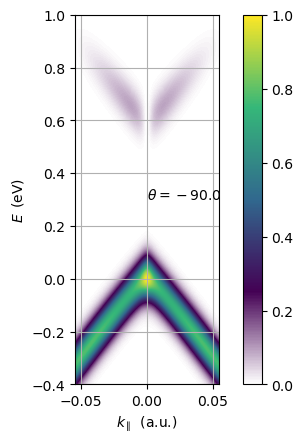

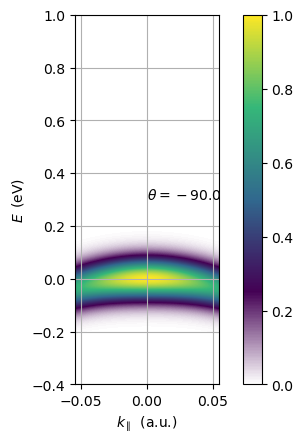

-0.0740848094

In [5]:
alpha = 54

#=======================================================================================
scissor_index = 20
#scissor_energy = 0.36117191605020593 / cst.Ry
scissor_energy = 0.557171916050206 / cst.Ry
Eshift = -6.5928465615388765#/ cst.Ry
#=======================================================================================

#=======================================================================================
#scissor_index = 20
#scissor_energy = 0.0 / cst.Ry
#Eshift = 0.47760658643687776# / cst.Ry
#=======================================================================================

ibnd_min = 19
ibnd_max = 20
bands = np.arange(ibnd_min, ibnd_max+1, step=1)

#nkz = 41


wmin, wmax = -0.4 / cst.Ry, 1.0 / cst.Ry
Nepe = 301
ws = np.linspace(wmin, wmax, Nepe)

bandas_info = {
    'scissor_index': scissor_index,
    'scissor_energy':scissor_energy
}

kpath = {
    'nk': 128,
    #'kmin': -0.14 * cst.aB,
    #'kmax':  0.14 * cst.aB,
    'kmin': -0.0543825,
    'kmax':  0.0543825,
    'angulo': 0*30/180*np.pi
}

photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    'rint': [0.2, 1.0, 2.0],
    #'rint': [0.2, 3.8, 2.0],
    'eta': 0.002
    #'eta': 0.0003
}

# probe
geo = LightGeometry(alpha/180. * np.pi, 0.0, 1.0)
pol_p = geo.GetPol_p_i()
pol_s = geo.GetPol_s_i()

print(pol_p,pol_s)

#kpath['dir'] = 'y'
#polarization = {'tag': 's', 'vector': pol_s}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

#polarization = {'tag': 'p', 'vector': pol_p}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)


photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [4.2, 3.8, 2.0],
    #'eta': 0.002
    'eta': 0.002
}

kpath['dir'] = 'y'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath['dir'] = 'x'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

#polarization = {'tag': 'p', 'vector': pol_p}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)


"""photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [3.8, 3.8, 2.5],
    #'eta': 0.002
    'eta': 0.002
}

kpath['dir'] = 'y'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)


polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)"""

"""kpath['dir'] = 'x'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath = {
    'nk': 128,
    'kmin': -0.14 * cst.aB,
    'kmax':  0.14 * cst.aB,
    'angulo': 15/180*np.pi
}
kpath['dir'] = 'dif'
#polarization = {'tag': 's', 'vector': pol_s}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath = {
    'nk': 128,
    'kmin': -0.14 * cst.aB,
    'kmax':  0.14 * cst.aB,
    'angulo': -75/180*np.pi
}
kpath['dir'] = 'dif'
#polarization = {'tag': 's', 'vector': pol_s}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath = {
    'nk': 128,
    'kmin': -0.14 * cst.aB,
    'kmax':  0.14 * cst.aB,
    'angulo': -75/180*np.pi
}
kpath['dir'] = 'dif'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

#polarization = {'tag': 'p', 'vector': pol_p}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)
""";
-0.14 * cst.aB

4554.85212960879


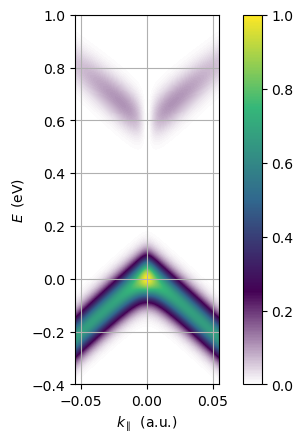

10965.464261159163


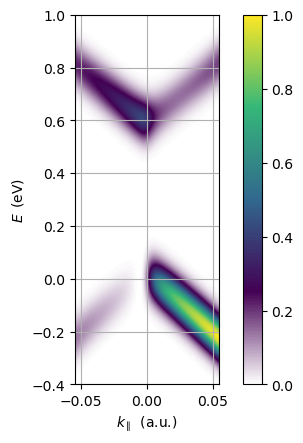

In [47]:
alpha = 54
theta=45
#gamma = 

#=======================================================================================
scissor_index = 20
#scissor_energy = 0.36117191605020593 / cst.Ry
scissor_energy = 0.557171916050206 / cst.Ry
Eshift = -6.5928465615388765#/ cst.Ry
#=======================================================================================

#=======================================================================================
#scissor_index = 20
#scissor_energy = 0.0 / cst.Ry
#Eshift = 0.47760658643687776# / cst.Ry
#=======================================================================================

ibnd_min = 19
ibnd_max = 20
bands = np.arange(ibnd_min, ibnd_max+1, step=1)

#nkz = 41


wmin, wmax = -0.4 / cst.Ry, 1.0 / cst.Ry
Nepe = 301
ws = np.linspace(wmin, wmax, Nepe)

bandas_info = {
    'scissor_index': scissor_index,
    'scissor_energy':scissor_energy
}

kpath = {
    'nk': 128,
    'kmin': -0.0543825,# * cst.aB,
    'kmax':  0.0543825,# * cst.aB,
    #'angulo': 30/180*np.pi
    #'angulo': (theta + np.pi/2)/180*np.pi
    'angulo': (theta+90)/180*np.pi
}

photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [4.2, 3.8, 2.0],
    #'eta': 0.002
    'eta': 0.002
}

# probe
geo = LightGeometry(alpha/180. * np.pi, theta/180. * np.pi, 1.0)
pol_p = geo.GetPol_p_i()
pol_s = geo.GetPol_s_i()

gamma = 0/180 * np.pi 

pol_1 = pol_p*np.cos(gamma) + pol_s*np.sin(gamma)
pol_2 = pol_s*np.cos(gamma) - pol_p*np.sin(gamma)

#print(pol_p,pol_s)

kpath['dir'] = 'dif'
polarization = {'tag': 's', 'vector': pol_2}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_1}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)


photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [4.2, 3.8, 2.0],
    #'eta': 0.002
    'eta': 0.002
}

#kpath['dir'] = 'y'
#polarization = {'tag': 's', 'vector': pol_1}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

#polarization = {'tag': 'p', 'vector': pol_2}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)


"""photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [3.8, 3.8, 2.5],
    #'eta': 0.002
    'eta': 0.002
}

kpath['dir'] = 'y'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)


polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)"""

"""kpath['dir'] = 'x'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath = {
    'nk': 128,
    'kmin': -0.14 * cst.aB,
    'kmax':  0.14 * cst.aB,
    'angulo': 15/180*np.pi
}
kpath['dir'] = 'dif'
#polarization = {'tag': 's', 'vector': pol_s}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath = {
    'nk': 128,
    'kmin': -0.14 * cst.aB,
    'kmax':  0.14 * cst.aB,
    'angulo': -75/180*np.pi
}
kpath['dir'] = 'dif'
#polarization = {'tag': 's', 'vector': pol_s}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

polarization = {'tag': 'p', 'vector': pol_p}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

kpath = {
    'nk': 128,
    'kmin': -0.14 * cst.aB,
    'kmax':  0.14 * cst.aB,
    'angulo': -75/180*np.pi
}
kpath['dir'] = 'dif'
polarization = {'tag': 's', 'vector': pol_s}
GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)

#polarization = {'tag': 'p', 'vector': pol_p}
#GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)
""";

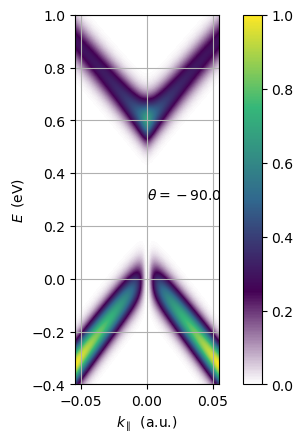

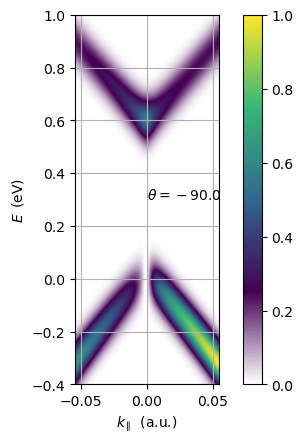

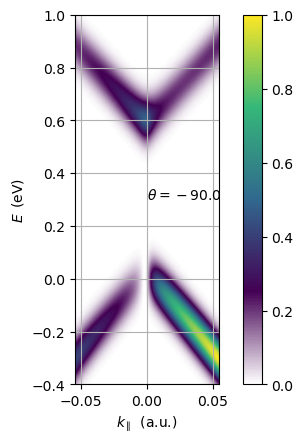

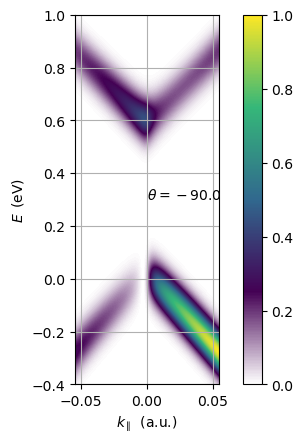

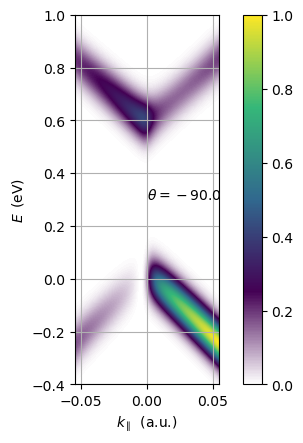

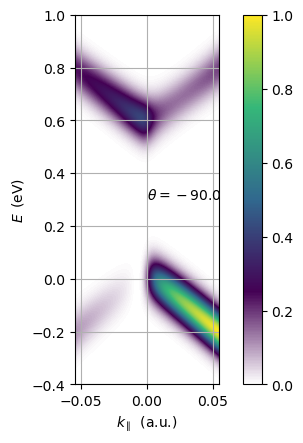

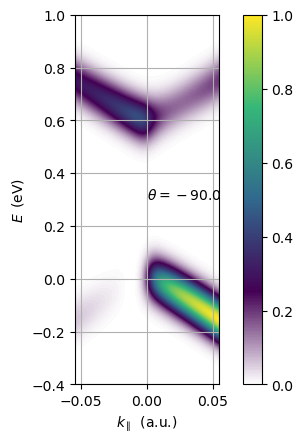

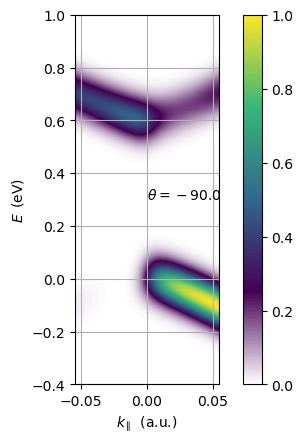

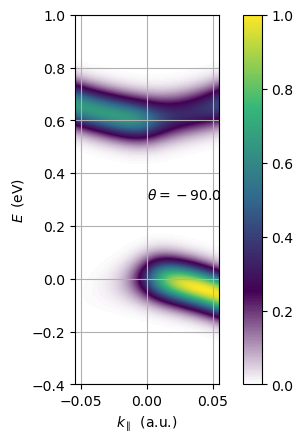

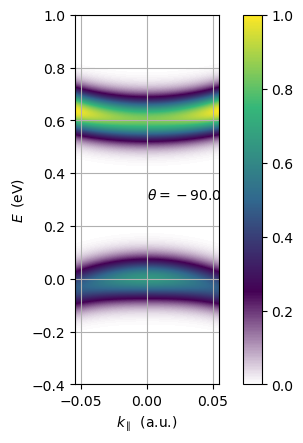

In [3]:
alpha = 54
gamma = 0/180 * np.pi 
#=======================================================================================
scissor_index = 20
#scissor_energy = 0.36117191605020593 / cst.Ry
scissor_energy = 0.557171916050206 / cst.Ry
Eshift = -6.5928465615388765#/ cst.Ry
#=======================================================================================

ibnd_min = 19
ibnd_max = 20
bands = np.arange(ibnd_min, ibnd_max+1, step=1)

#nkz = 41


wmin, wmax = -0.4 / cst.Ry, 1.0 / cst.Ry
Nepe = 301
ws = np.linspace(wmin, wmax, Nepe)

bandas_info = {
    'scissor_index': scissor_index,
    'scissor_energy':scissor_energy
}


photon = {
    'wphot': 6.2,
    'alpha': alpha,
    'Vin': 0.0,
    'Phiw': 4.95409,
    'Eshift': Eshift,
    #'rint': [0.2, 1.0, 2.0],
    'rint': [4.2, 3.8, 2.0],
    #'eta': 0.002
    'eta': 0.002
}

thetas = np.linspace(0,90,10)

for i,θ  in enumerate(thetas):
    geo = LightGeometry(alpha/180. * np.pi, θ/180. * np.pi, 1.0)
    pol_p = geo.GetPol_p_i()
    pol_s = geo.GetPol_s_i()

    pol_1 = pol_p*np.cos(gamma) + pol_s*np.sin(gamma)
    pol_2 = pol_s*np.cos(gamma) - pol_p*np.sin(gamma)
    
    kpath = {
        'nk': 128,
        'kmin': -0.0543825,# * cst.aB,
        'kmax':  0.0543825,# * cst.aB,
        #'angulo': 30/180*np.pi
        #'angulo': (theta + np.pi/2)/180*np.pi
        'angulo': (θ+90)/180*np.pi
    }
    
    kpath['dir'] = 'dif'
    polarization = {'tag': 'p', 'vector': pol_1}
    GenMatrixElements(ws,kpath,polarization,bands,bandas_info,photon)